# El niño efects?

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point
import os
import seaborn as sns
from shapely.ops import nearest_points

#### cargue los datos

In [19]:
npfile   = np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\theilslopes_DTW.npz')

In [20]:
syr      = npfile.f.dtw_syr
condyr   = npfile.f.dtw_condyr
s_nmax_yr= npfile.f.dtw_s_nmax_yr
nmax_yr  = npfile.f.dtw_nmax_yr
vyr      = npfile.f.dtw_vyr
tyr      = npfile.f.dtw_tyr
lat      = npfile.f.lat
lon      = npfile.f.lon
interc_t = npfile.f.dtw_interc_t
slop_t   = npfile.f.dtw_slop_t

ndat = len(condyr)
ngood = np.count_nonzero(condyr==1)

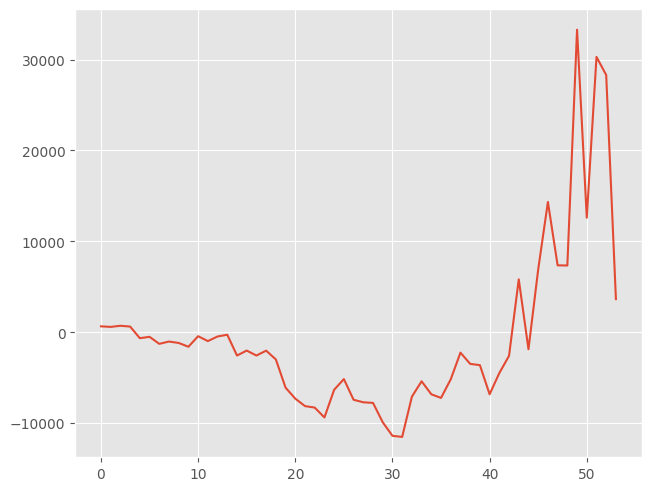

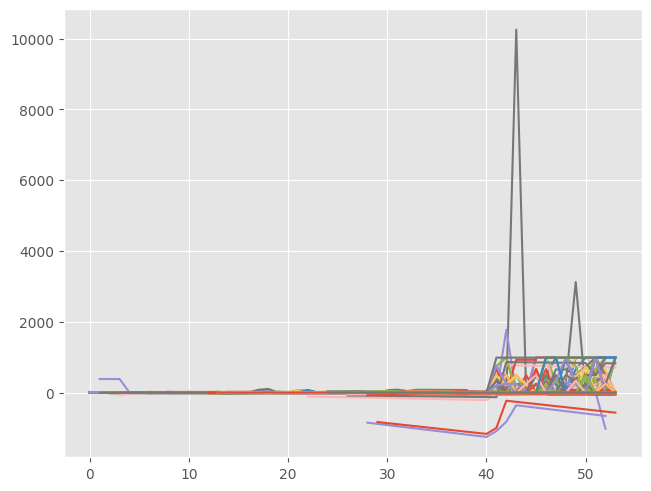

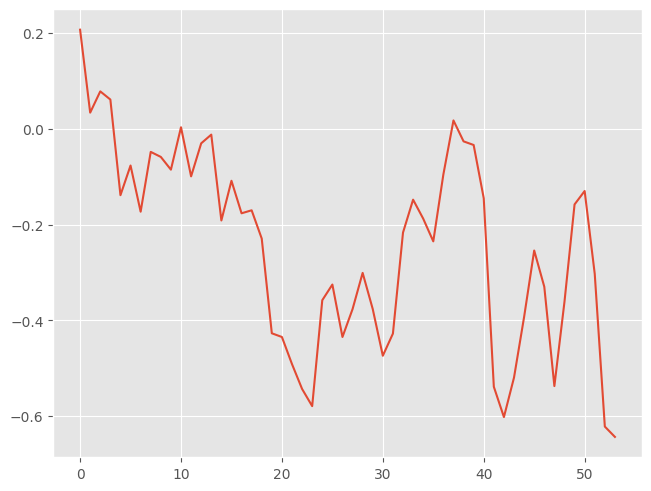

(54, 13255)


In [21]:
t_all = tyr[1,:]
tmin  = np.min(t_all)-1
tmax  = np.max(t_all)+1

vmat   = np.zeros((len(t_all),ngood))
vstack = np.zeros(len(t_all))
vstack[:] = np.nan
vmat[:]   = np.nan

ncnt = -1
for i in range(ndat):
    if (condyr[i]==0):
        continue
    ncnt = ncnt + 1
    # Puntos válidos
    #print(syr[i], condyr[i])
    #print(s_nmax_yr[i],nmax_yr[i])
    i0 = s_nmax_yr[i]
    i1 = i0+nmax_yr[i]
    t  = t_all[i0:i1]
    pline = t*slop_t[i] + interc_t[i]

    res   = vyr[i,i0:i1]-pline
    res = np.nan_to_num(res)
    vstack[i0:i1] = np.where(np.isnan(vstack[i0:i1]), res, vstack[i0:i1] + res)
    vmat[i0:i1,ncnt] = res

    continue
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(t_all,vyr[i,:],'lightgray')
    ax1.plot(t,vyr[i,i0:i1],'k')
    ax1.plot(t,pline)
    ax1.set_xlim(tmin,tmax)
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(t,res) 
    ax2.plot(t_all,vstack,'lightgray')
    ax2.set_xlim(tmin,tmax)

fig = plt.figure()
plt.plot(t_all,vstack)
plt.show()

fig = plt.figure()
plt.plot(t_all,vmat)
plt.show()

fig = plt.figure()
plt.plot(t_all,np.nanmedian(vmat,axis=1))
plt.show()

print(np.shape(vmat))

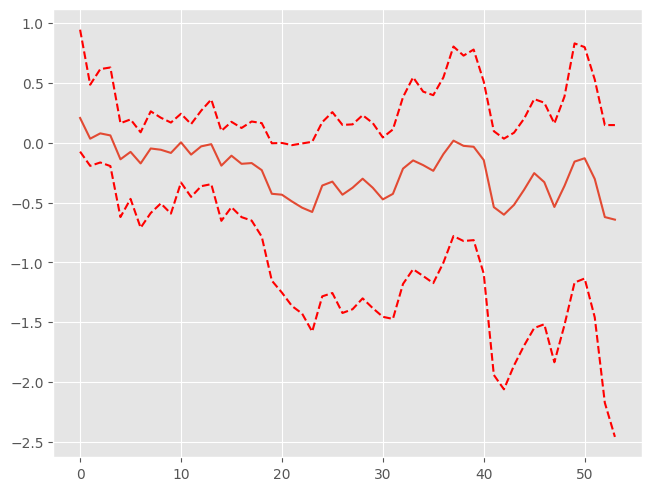

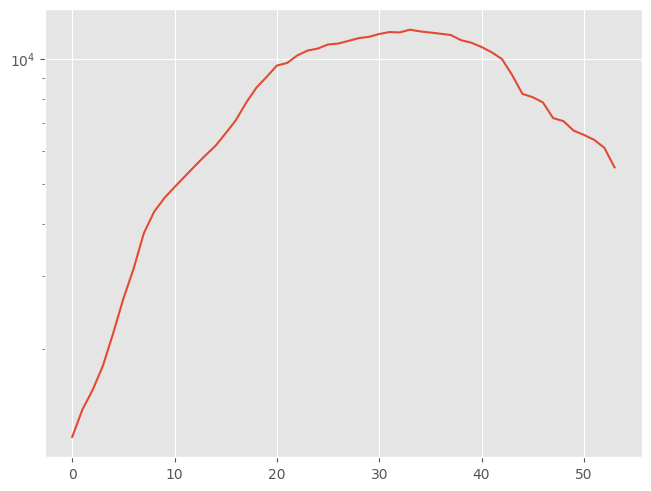

In [22]:
# Select the good per year

p25  = np.zeros(len(t_all))
p50  = np.zeros(len(t_all))
p75  = np.zeros(len(t_all))
nobs = np.zeros(len(t_all))

for i in range(54):
    igood = np.where(np.invert(np.isnan(vmat[i,:])))[0]
    yeardat = vmat[i,igood]
    nobs[i] = len(igood)
    p25[i] = np.percentile(yeardat, 25)
    p50[i] = np.percentile(yeardat, 50)
    p75[i] = np.percentile(yeardat, 75)
    #print(np.percentile(yeardat, 25),np.percentile(yeardat, 50),np.percentile(yeardat, 75))

    
    #print(vmat[i,igood])

    continue
    
    plt.figure()
    plt.hist(yeardat,np.linspace(-10,10))
    plt.plot([p25,p50,p75],[0,0,0],'x')

plt.figure()
plt.plot(p50)
plt.plot(p25,'r--')
plt.plot(p75,'r--')

plt.figure()
plt.semilogy(nobs)

(-5.0, 5.0)

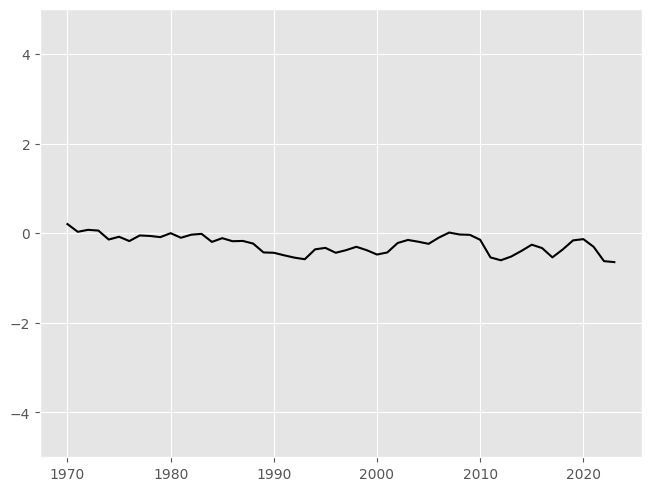

In [23]:
N = ngood
#plt.plot(vmat[:,0:N],'.')
plt.plot(t_all+1970,np.nanmedian(vmat[:,0:N],axis=1),'k-')
plt.ylim(-5,5)

#### Cuencas hidrogeológicas

In [24]:
# Cargar el shapefile de cuencas
ruta_shapefile = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\australia_aquifers.shp'
cuencas = gpd.read_file(ruta_shapefile)

# Verificar la columna 'Broader' que contiene las cuencas
print(cuencas['Broader'].unique())  # Mostrar las cuencas disponibles

['-' 'Gippsland Basin' 'Otway Basin' 'Murray Basin' 'St Vincent Basin'
 'Eucla Basin' 'Great Artesian Basin' 'Perth Basin' 'Amadeus Basin'
 'Daly-Wiso-Georgina Basins' 'Hamersley Basin' 'Pilbara Craton']


In [25]:
# Crear GeoDataFrame con las ubicaciones de tus datos
geometry = [Point(lon, lat) for lon, lat in zip(lon, lat)]  # lon y lat de tus datos
gdf_datos = gpd.GeoDataFrame({'id': np.arange(len(lon))}, geometry=geometry, crs=cuencas.crs)

# Realizar la unión espacial - VERSIÓN CORREGIDA
datos_por_cuenca = gpd.sjoin(gdf_datos, cuencas, how='left', predicate='within')

In [26]:
cuencas_unicas = cuencas['Broader'].unique()

# Diccionario para almacenar resultados por cuenca
resultados_por_cuenca = {}

for cuenca in cuencas_unicas:
    # Filtrar índices que pertenecen a esta cuenca
    idx_cuenca = datos_por_cuenca[datos_por_cuenca['Broader'] == cuenca].index
    
    # Inicializar matrices para esta cuenca (similar al código original)
    vmat_cuenca = np.zeros((len(t_all), len(idx_cuenca))) * np.nan
    ncnt = -1
    
    for i in idx_cuenca:
        if condyr[i] == 0:
            continue
        ncnt += 1
        i0 = s_nmax_yr[i]
        i1 = i0 + nmax_yr[i]
        t = t_all[i0:i1]
        pline = t * slop_t[i] + interc_t[i]
        res = vyr[i,i0:i1] - pline
        res = np.nan_to_num(res)
        vmat_cuenca[i0:i1, ncnt] = res
    
    # Calcular estadísticas para esta cuenca
    p25, p50, p75, nobs = [], [], [], []
    for i in range(len(t_all)):
        yeardat = vmat_cuenca[i, ~np.isnan(vmat_cuenca[i,:])]
        nobs.append(len(yeardat))
        if len(yeardat) > 0:
            p25.append(np.percentile(yeardat, 25))
            p50.append(np.percentile(yeardat, 50))
            p75.append(np.percentile(yeardat, 75))
        else:
            p25.append(np.nan)
            p50.append(np.nan)
            p75.append(np.nan)
    
    resultados_por_cuenca[cuenca] = {
        'p25': p25,
        'p50': p50,
        'p75': p75,
        'nobs': nobs,
        'vmat': vmat_cuenca
    }

In [27]:
### guardar npz de residuales por cuencas:
output_dir = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\residuales\cuencas'
os.makedirs(output_dir, exist_ok=True)

# Lista de cuencas (las que mencionaste)
cuencas_unicas = ['-', 'Gippsland Basin', 'Otway Basin', 'Murray Basin', 
                 'St Vincent Basin', 'Eucla Basin', 'Great Artesian Basin', 
                 'Perth Basin', 'Amadeus Basin', 'Daly-Wiso-Georgina Basins', 
                 'Hamersley Basin', 'Pilbara Craton']

for cuenca in cuencas_unicas:
    # Verificar si hay datos para esta cuenca
    if cuenca not in resultados_por_cuenca or np.sum(resultados_por_cuenca[cuenca]['nobs']) == 0:
        print(f"Saltando {cuenca} (sin datos)")
        continue
    
    # Crear nombre de archivo seguro
    nombre_archivo = f"residuales_{cuenca.replace(' ', '_').replace('-', '_').replace('/', '_')}.npz"
    ruta_completa = os.path.join(output_dir, nombre_archivo)
    
    # Datos a guardar (estructura optimizada)
    np.savez(
        ruta_completa,
        nombre_cuenca=cuenca,                    
        years=t_all + 1970,                     
        residuales=resultados_por_cuenca[cuenca]['vmat'], 
        p25=np.array(resultados_por_cuenca[cuenca]['p25']),
        p50=np.array(resultados_por_cuenca[cuenca]['p50']),
        p75=np.array(resultados_por_cuenca[cuenca]['p75']),
        nobs=np.array(resultados_por_cuenca[cuenca]['nobs'])
    )
    print(f"Guardado: {nombre_archivo}")

print("¡Proceso completado! Archivos guardados en:", output_dir)

Guardado: residuales__.npz
Guardado: residuales_Gippsland_Basin.npz
Guardado: residuales_Otway_Basin.npz
Guardado: residuales_Murray_Basin.npz
Guardado: residuales_St_Vincent_Basin.npz
Guardado: residuales_Eucla_Basin.npz
Guardado: residuales_Great_Artesian_Basin.npz
Guardado: residuales_Perth_Basin.npz
Guardado: residuales_Amadeus_Basin.npz
Guardado: residuales_Daly_Wiso_Georgina_Basins.npz
Guardado: residuales_Hamersley_Basin.npz
Guardado: residuales_Pilbara_Craton.npz
¡Proceso completado! Archivos guardados en: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\residuales\cuencas


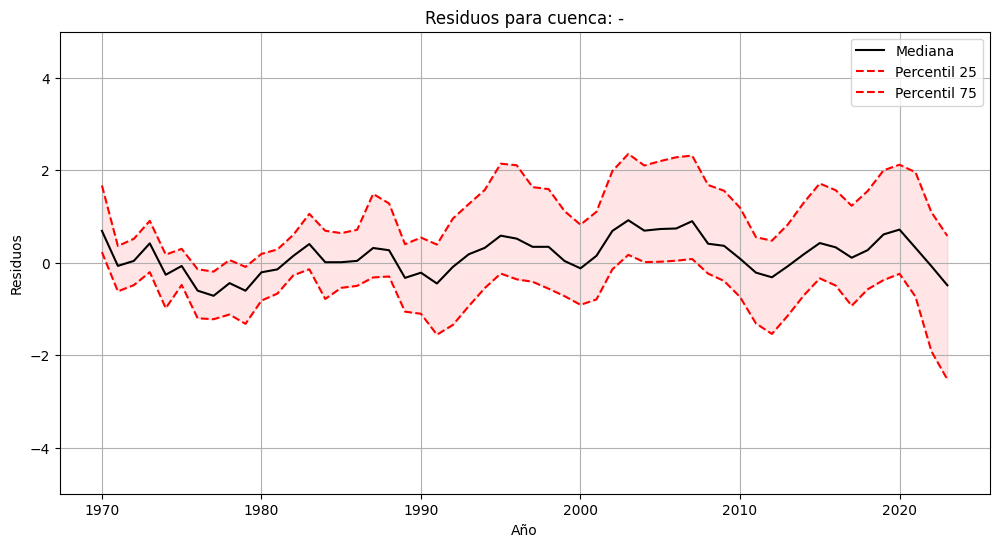

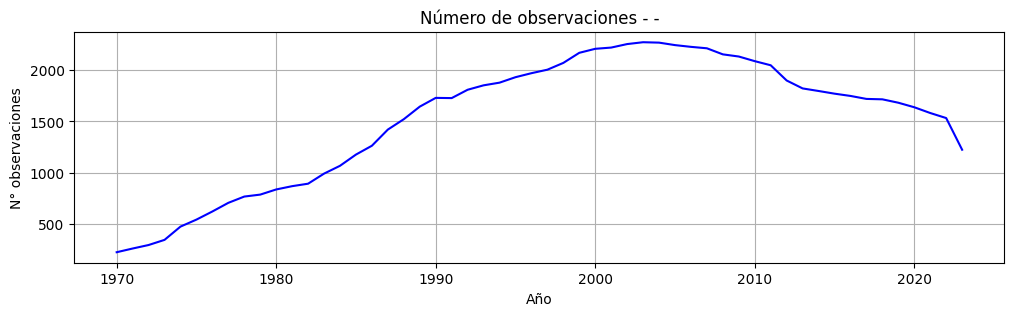

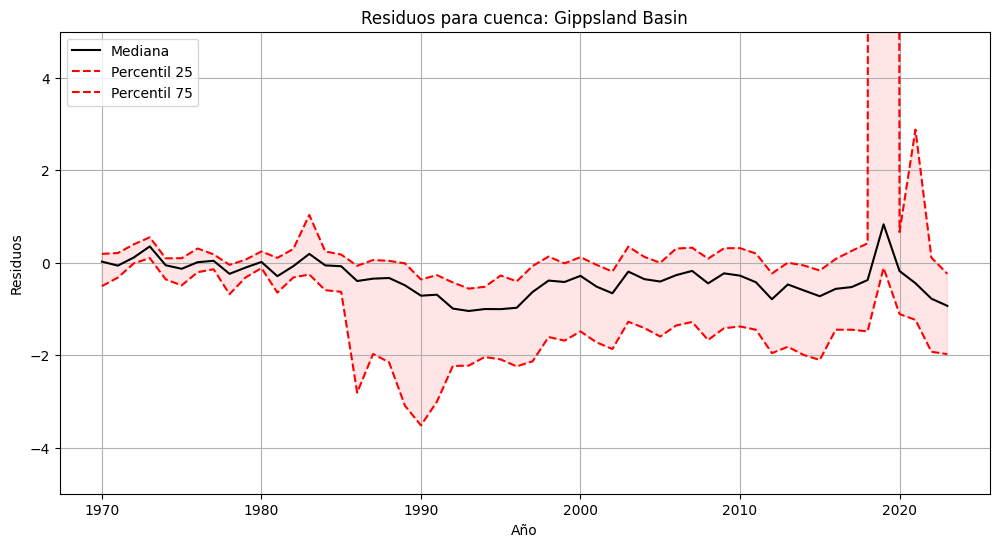

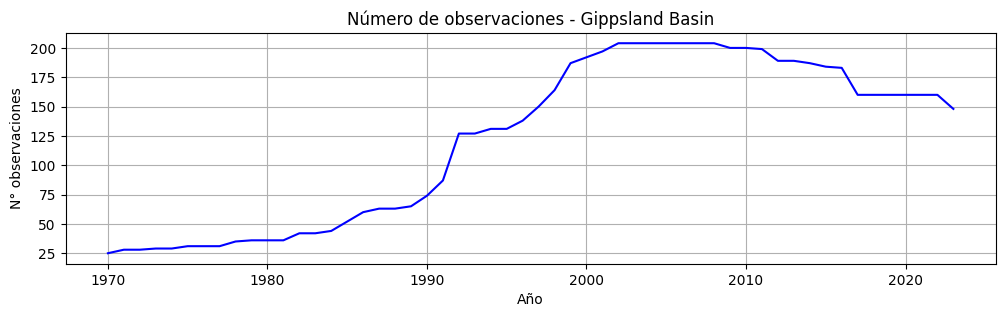

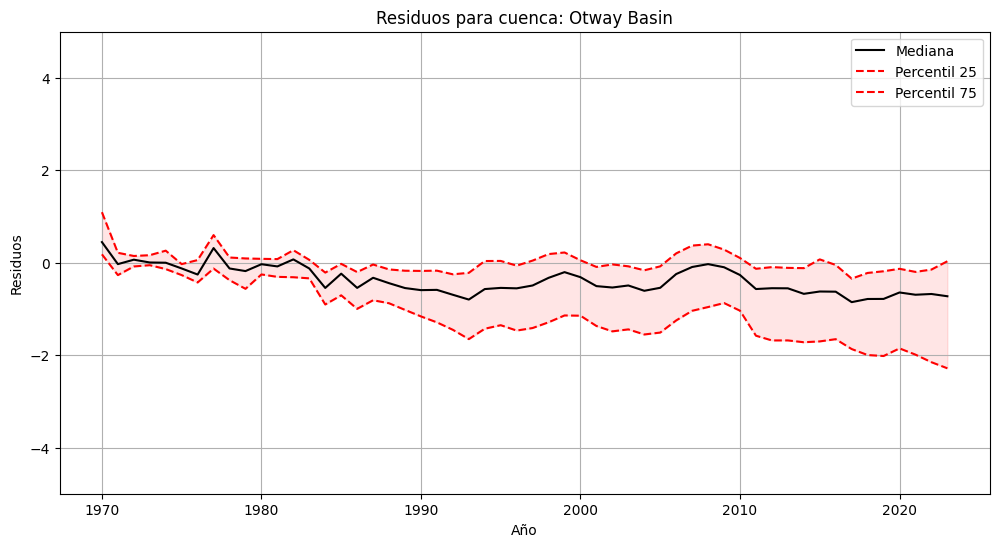

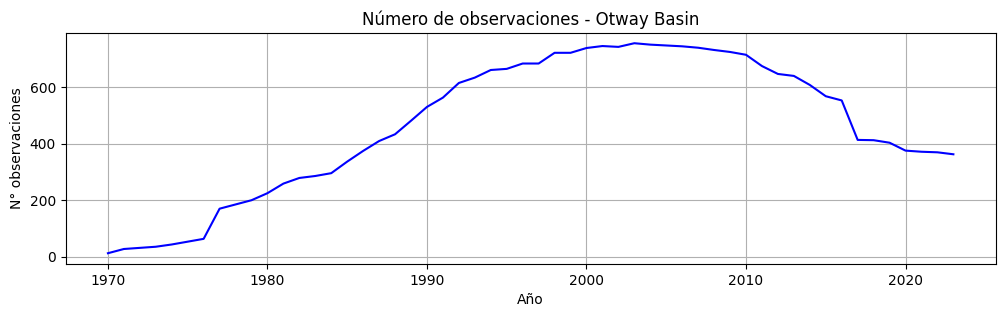

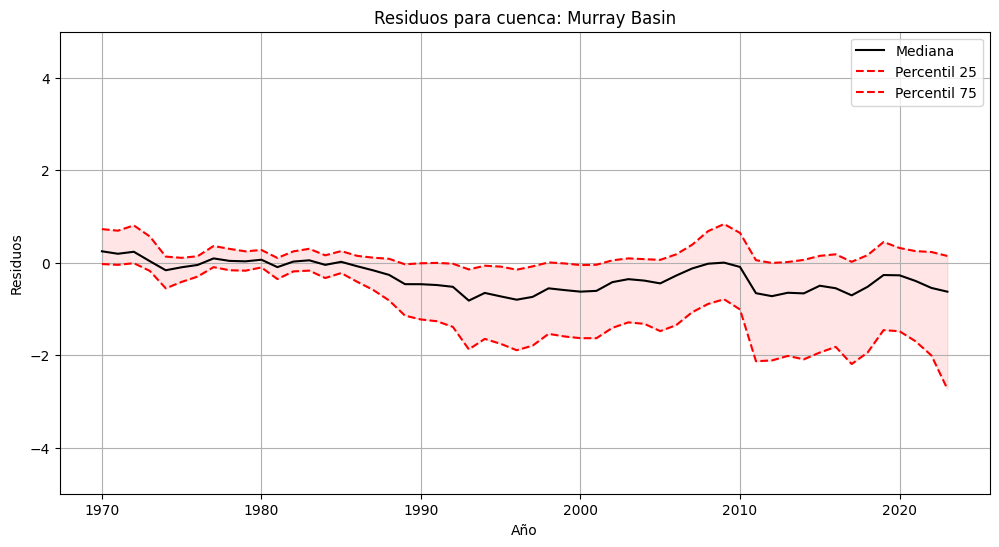

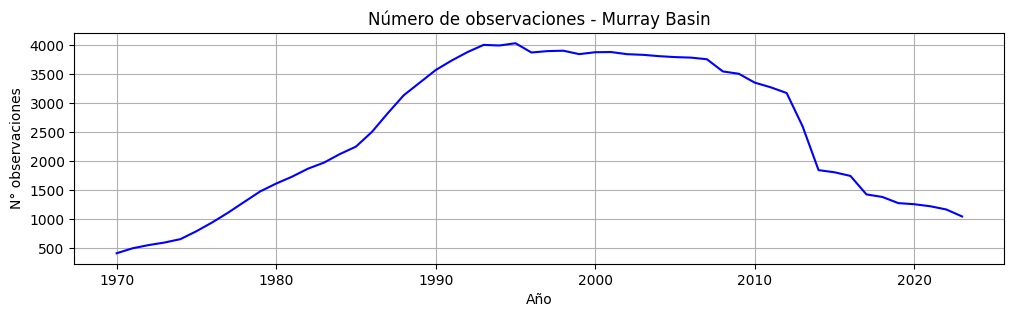

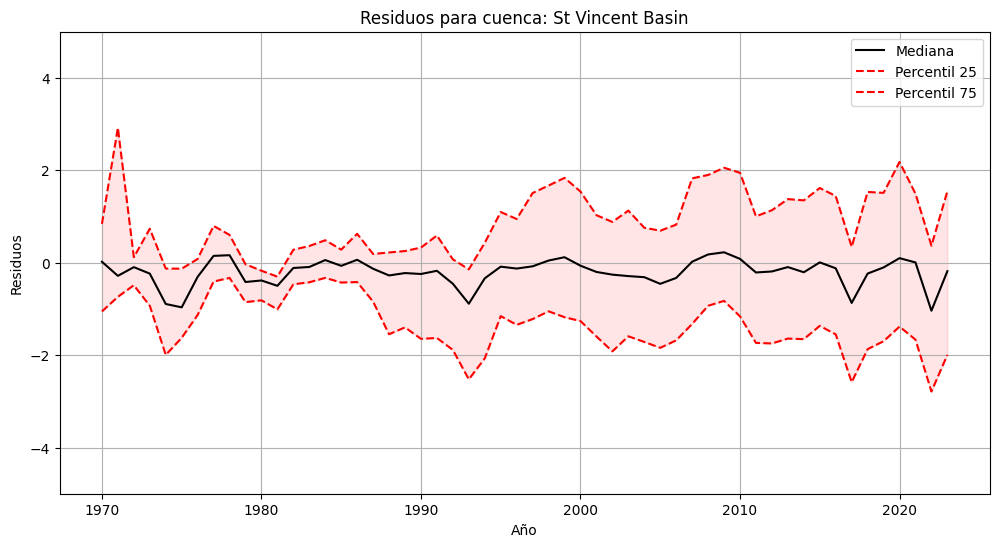

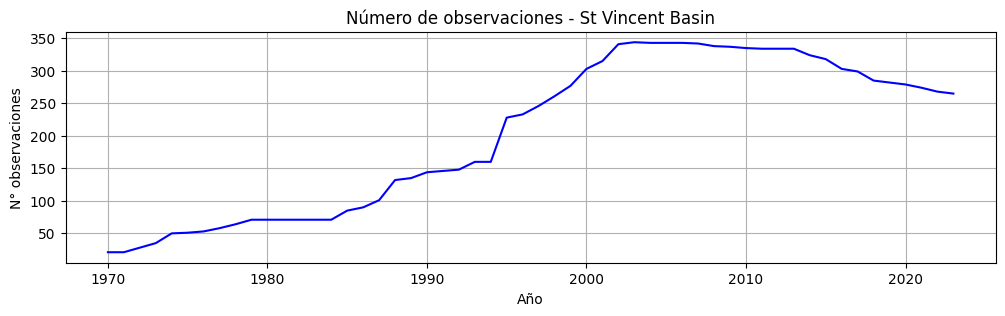

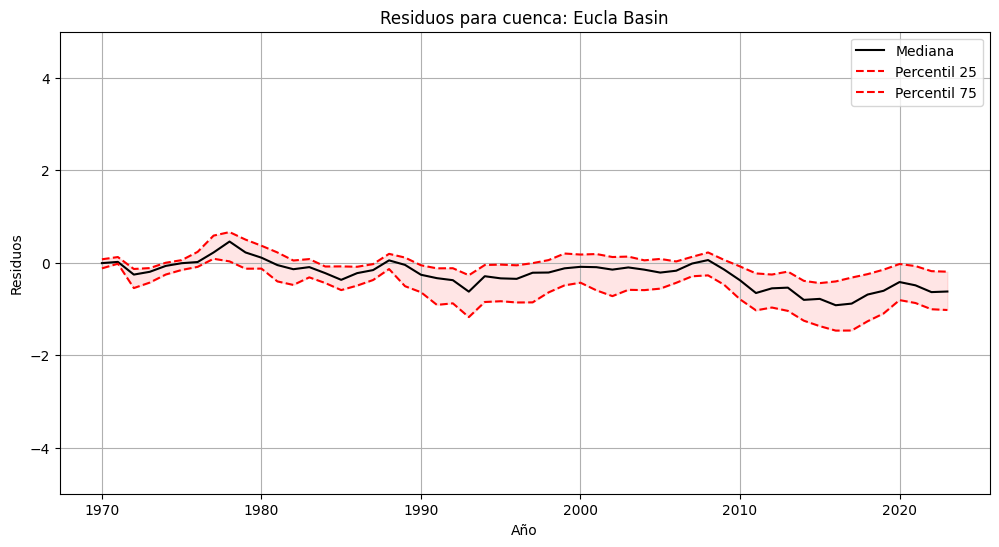

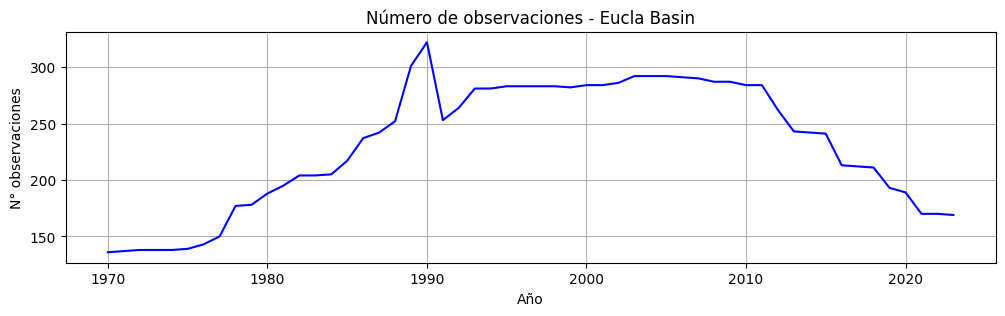

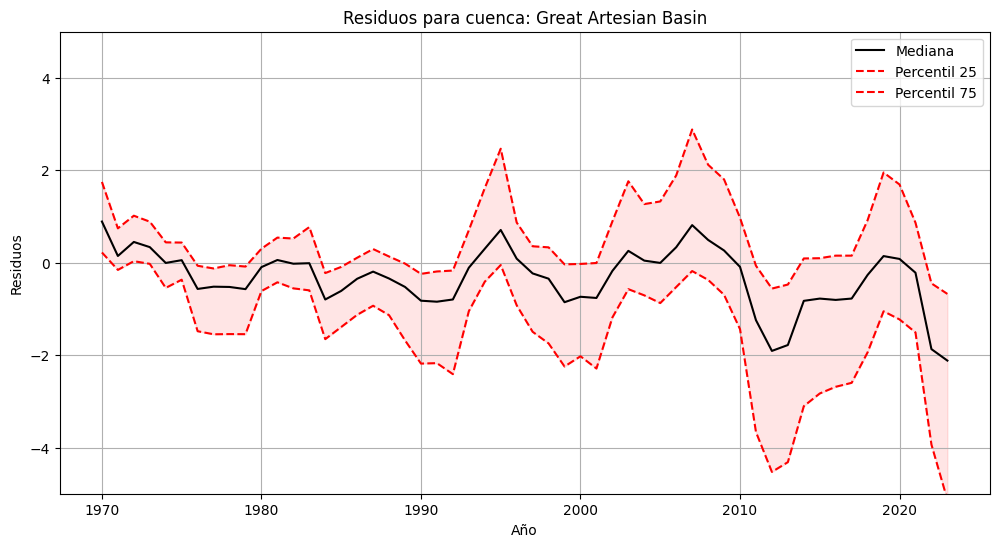

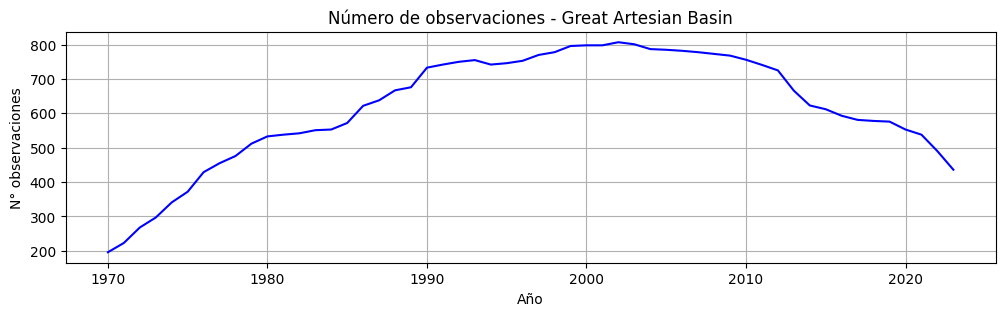

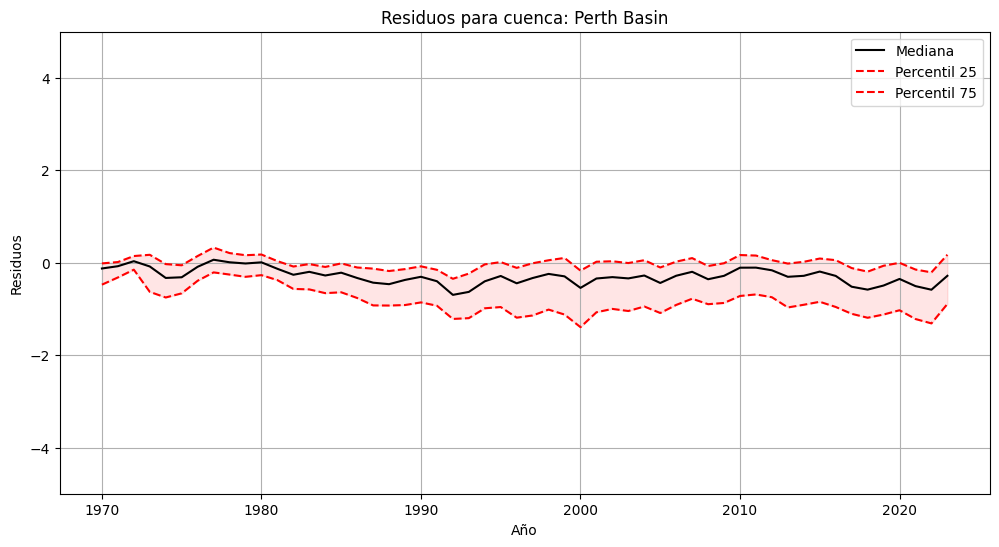

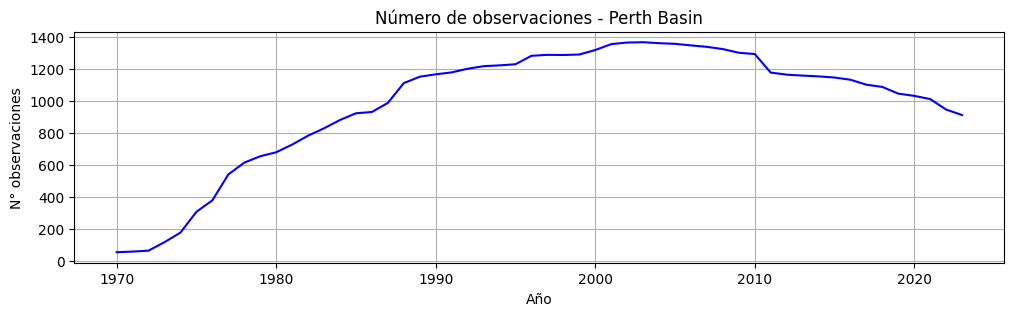

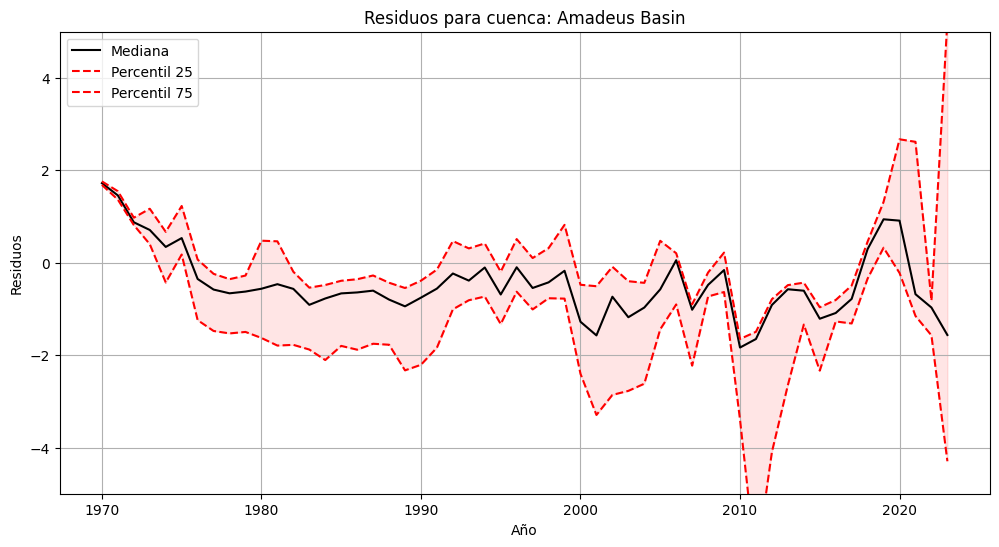

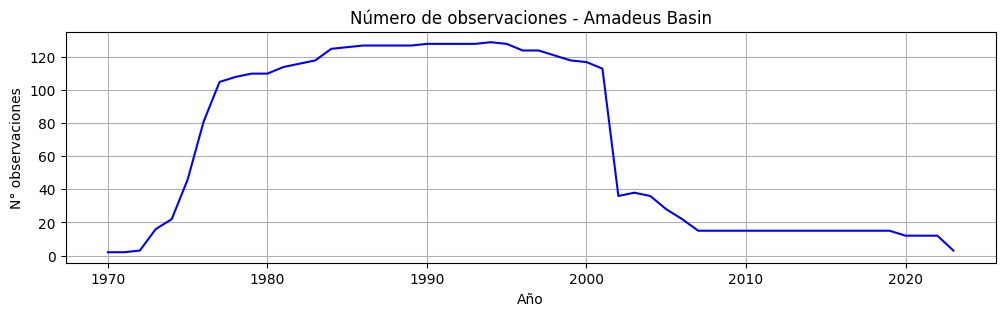

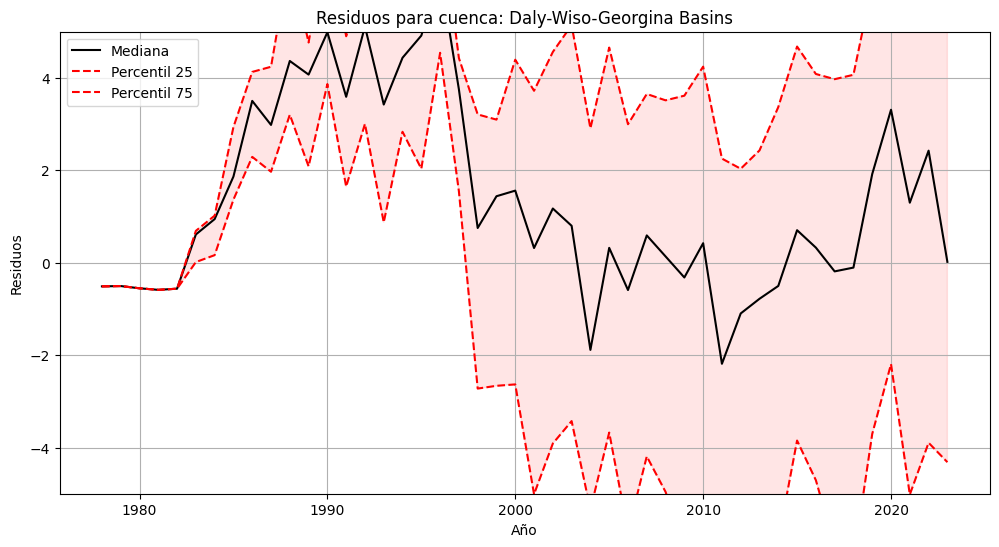

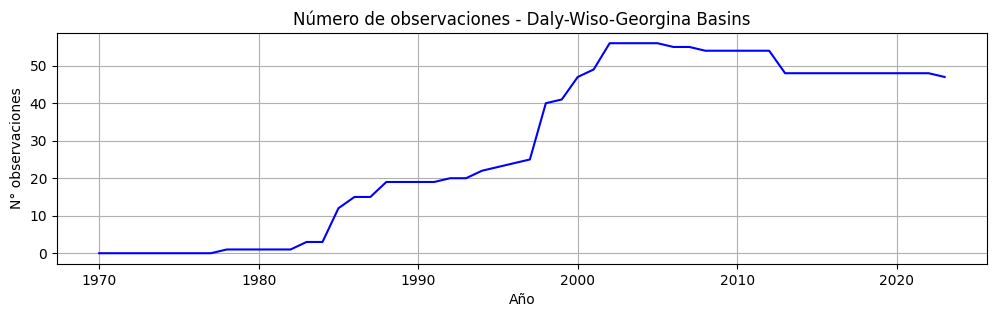

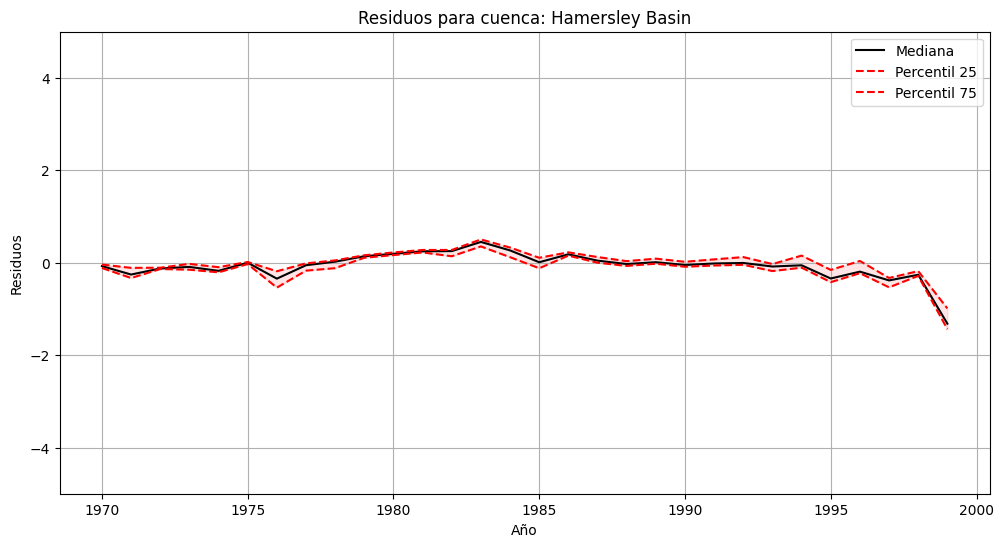

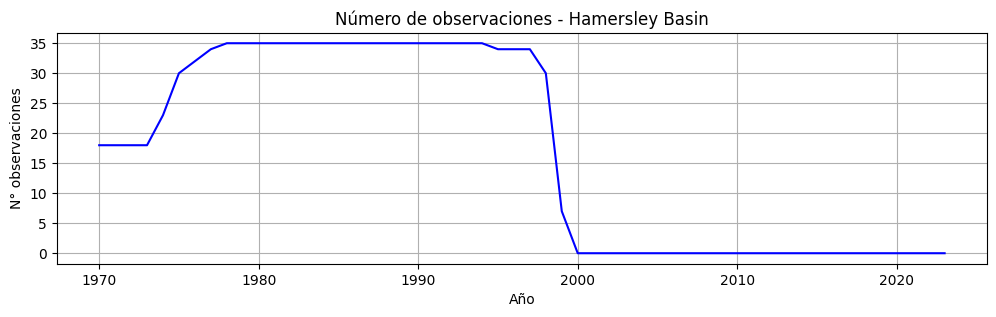

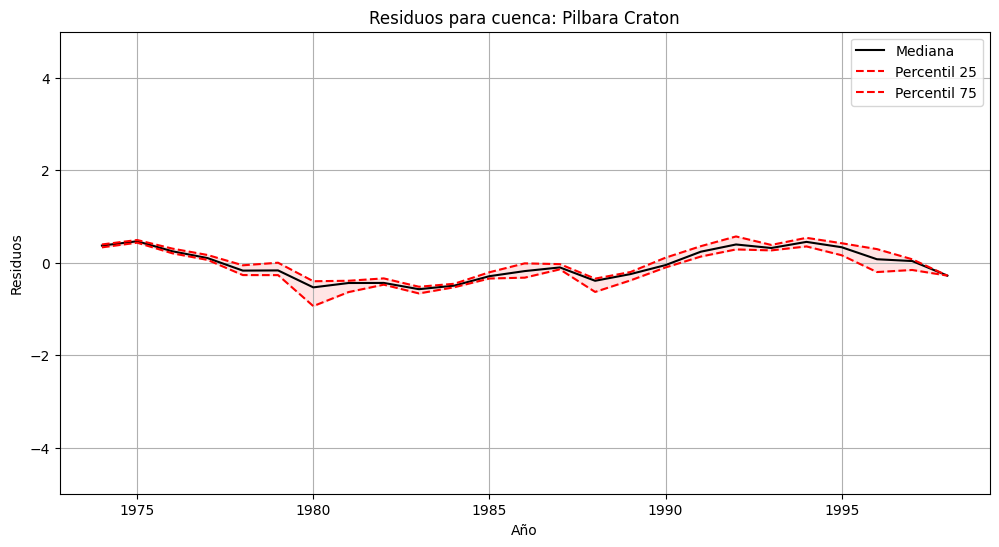

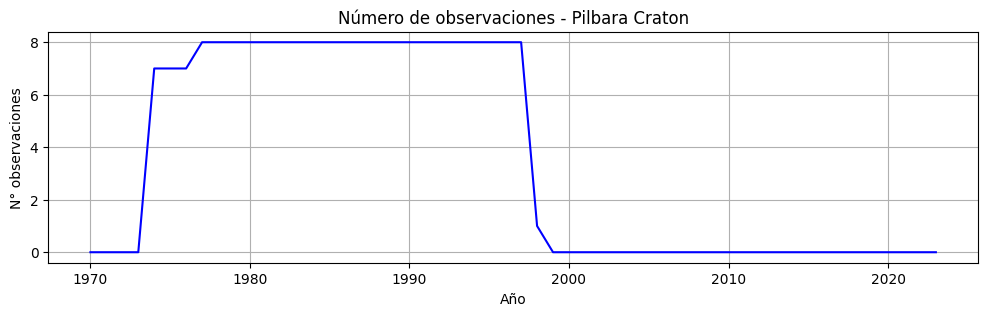

In [13]:
for cuenca, resultados in resultados_por_cuenca.items():
    if np.sum(resultados['nobs']) == 0:
        continue  # Saltar cuencas sin datos
    
    plt.figure(figsize=(12, 6))
    plt.title(f"Residuos para cuenca: {cuenca}")
    plt.plot(t_all + 1970, resultados['p50'], 'k-', label='Mediana')
    plt.plot(t_all + 1970, resultados['p25'], 'r--', label='Percentil 25')
    plt.plot(t_all + 1970, resultados['p75'], 'r--', label='Percentil 75')
    plt.fill_between(t_all + 1970, resultados['p25'], resultados['p75'], color='red', alpha=0.1)
    plt.ylim(-5, 5)
    plt.xlabel('Año')
    plt.ylabel('Residuos')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # También puedes graficar el número de observaciones
    plt.figure(figsize=(12, 3))
    plt.title(f"Número de observaciones - {cuenca}")
    plt.plot(t_all + 1970, resultados['nobs'], 'b-')
    plt.xlabel('Año')
    plt.ylabel('N° observaciones')
    plt.grid(True)
    plt.show()

In [13]:
##### Guardar imágenes de residuales

In [14]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

# Crear directorio para guardar las imágenes si no existe
output_dir = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales'
os.makedirs(output_dir, exist_ok=True)

for cuenca, resultados in resultados_por_cuenca.items():
    if np.sum(resultados['nobs']) == 0:
        continue  # Saltar cuencas sin datos
    
    # Configurar figura con dos subplots verticales
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle(f"Análisis de residuos - Cuenca: {cuenca}", fontsize=14)
    
    # Usar GridSpec para controlar el espacio de los subplots
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)
    
    # Primer subplot: Residuos
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(t_all + 1970, resultados['p50'], 'k-', label='Mediana')
    ax1.plot(t_all + 1970, resultados['p25'], 'r--', label='Percentil 25-75')
    ax1.plot(t_all + 1970, resultados['p75'], 'r--')
    ax1.fill_between(t_all + 1970, resultados['p25'], resultados['p75'], 
                    color='red', alpha=0.1)
    ax1.set_ylim(-5, 5)
    ax1.set_ylabel('Residuos (mm)')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Segundo subplot: Número de observaciones
    ax2 = fig.add_subplot(gs[1])
    ax2.bar(t_all + 1970, resultados['nobs'], width=0.8, 
           color='blue', alpha=0.7)
    ax2.set_xlabel('Año')
    ax2.set_ylabel('N° observaciones')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    # Ajustar límites del eje x para alinear ambos subplots
    ax1.set_xlim(min(t_all + 1970)-0.5, max(t_all + 1970)+0.5)
    ax2.set_xlim(min(t_all + 1970)-0.5, max(t_all + 1970)+0.5)
    
    # Eliminar el año en el subplot superior
    ax1.set_xticklabels([])
    
    # Guardar la figura
    nombre_archivo = f"residuos_{cuenca.replace('/', '_').replace(' ', '_')}.png"
    ruta_completa = os.path.join(output_dir, nombre_archivo)
    plt.savefig(ruta_completa, dpi=300, bbox_inches='tight')
    plt.close()  # Cerrar la figura para liberar memoria
    
    print(f"Gráfico guardado: {ruta_completa}")

Gráfico guardado: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\residuos_-.png
Gráfico guardado: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\residuos_Gippsland_Basin.png
Gráfico guardado: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\residuos_Otway_Basin.png
Gráfico guardado: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\residuos_Murray_Basin.png
Gráfico guardado: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\residuos_St_Vincent_Basin.png
Gráfico guardado: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\residuos_Eucla_Basin.png
Gráfico guardado: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\residuos_Great_Artesian_Basin.png
Gráfico guardado: G:\Mi unidad\Maestria\Proyec

#### Residuales por grilla

KeyboardInterrupt: 

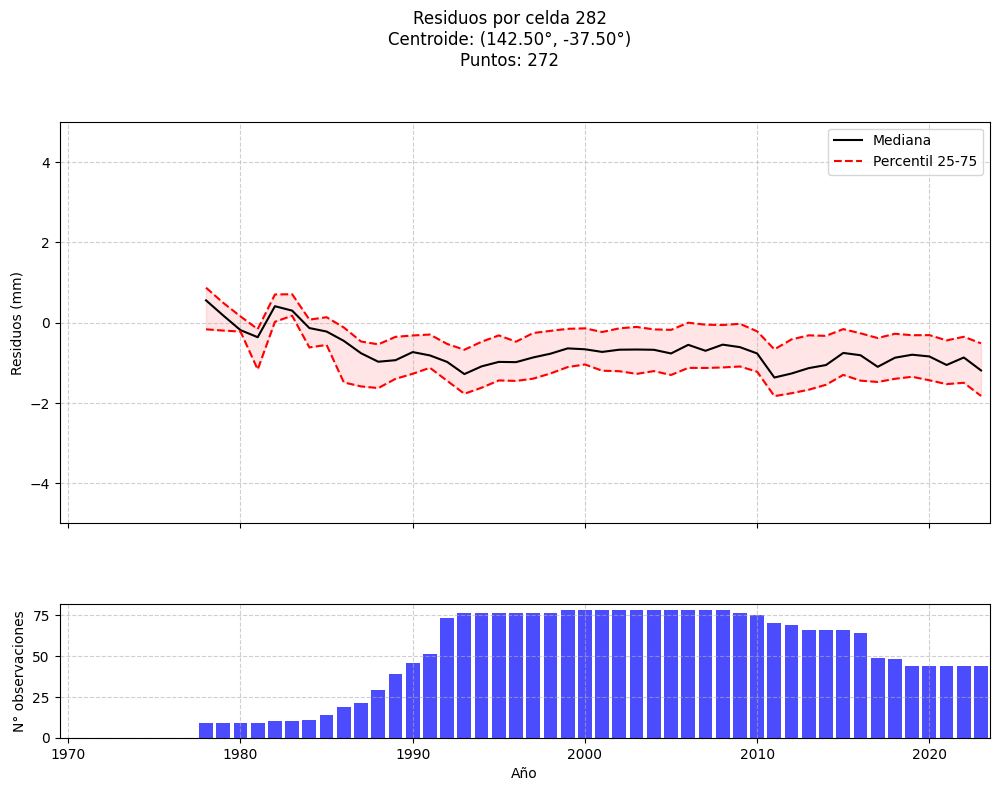

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon as MplPolygon
import os
from shapely.geometry import Polygon, Point

# 1. Primero extraer todos los datos necesarios del archivo NPZ
with np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\theilslopes_DTW.npz') as npfile:
    # Extraer todas las variables necesarias
    lat = npfile['lat']
    lon = npfile['lon']
    vyr = npfile['dtw_vyr']
    tyr = npfile['dtw_tyr']
    slop_t = npfile['dtw_slop_t']
    interc_t = npfile['dtw_interc_t']
    condyr = npfile['dtw_condyr']
    s_nmax_yr = npfile['dtw_s_nmax_yr']
    nmax_yr = npfile['dtw_nmax_yr']

# Extraer t_all
t_all = tyr[1,:]

# 2. Configuración de la grilla
min_lat, max_lat = -44, -10
min_lon, max_lon = 112, 154
cell_size = 1.0
umbral_min_puntos = 20

# Crear la grilla
lat_edges = np.arange(min_lat, max_lat + cell_size, cell_size)
lon_edges = np.arange(min_lon, max_lon + cell_size, cell_size)
celdas = []

for i in range(len(lat_edges) - 1):
    for j in range(len(lon_edges) - 1):
        celdas.append(Polygon([
            [lon_edges[j], lat_edges[i]],
            [lon_edges[j + 1], lat_edges[i]],
            [lon_edges[j + 1], lat_edges[i + 1]],
            [lon_edges[j], lat_edges[i + 1]],
            [lon_edges[j], lat_edges[i]]
        ]))

# 3. Función para verificar puntos dentro de un polígono
def ptsinpoly(polygon, points_lat, points_lon):
    return [i for i, (plon, plat) in enumerate(zip(points_lon, points_lat)) 
            if polygon.contains(Point(plon, plat))]

# 4. Directorio de salida
output_dir = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\grillas'
os.makedirs(output_dir, exist_ok=True)

# 5. Procesar cada celda
for idx, celda in enumerate(celdas):
    # Obtener puntos dentro de la celda
    indices_dentro = ptsinpoly(celda, lat, lon)
    
    # Filtrar celdas con pocos puntos
    if len(indices_dentro) < umbral_min_puntos:
        continue
    
    # Inicializar matrices para esta celda
    vmat_celda = np.zeros((len(t_all), len(indices_dentro))) * np.nan
    ncnt = -1
    
    for i in indices_dentro:
        if condyr[i] == 0:
            continue
        ncnt += 1
        i0 = s_nmax_yr[i]
        i1 = i0 + nmax_yr[i]
        t = t_all[i0:i1]
        pline = t * slop_t[i] + interc_t[i]
        res = vyr[i,i0:i1] - pline
        res = np.nan_to_num(res)
        vmat_celda[i0:i1, ncnt] = res
    
    # Calcular estadísticas
    p25, p50, p75, nobs = [], [], [], []
    for i in range(len(t_all)):
        yeardat = vmat_celda[i, ~np.isnan(vmat_celda[i,:])]
        nobs.append(len(yeardat))
        if len(yeardat) > 0:
            p25.append(np.percentile(yeardat, 25))
            p50.append(np.percentile(yeardat, 50))
            p75.append(np.percentile(yeardat, 75))
        else:
            p25.append(np.nan)
            p50.append(np.nan)
            p75.append(np.nan)
    
    # Crear figura combinada
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)
    
    # Subplot 1: Residuos
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(t_all + 1970, p50, 'k-', label='Mediana')
    ax1.plot(t_all + 1970, p25, 'r--', label='Percentil 25-75')
    ax1.plot(t_all + 1970, p75, 'r--')
    ax1.fill_between(t_all + 1970, p25, p75, color='red', alpha=0.1)
    ax1.set_ylim(-5, 5)
    ax1.set_ylabel('Residuos (mm)')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Subplot 2: Número de observaciones
    ax2 = fig.add_subplot(gs[1])
    ax2.bar(t_all + 1970, nobs, width=0.8, color='blue', alpha=0.7)
    ax2.set_xlabel('Año')
    ax2.set_ylabel('N° observaciones')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    # Ajustar límites y título
    ax1.set_xlim(min(t_all + 1970)-0.5, max(t_all + 1970)+0.5)
    ax2.set_xlim(min(t_all + 1970)-0.5, max(t_all + 1970)+0.5)
    ax1.set_xticklabels([])
    
    # Añadir información de la celda
    center = celda.centroid.coords[0]
    fig.suptitle(f"Residuos por celda {idx}\nCentroide: ({center[0]:.2f}°, {center[1]:.2f}°)\nPuntos: {len(indices_dentro)}", 
                fontsize=12, y=1.02)
    
    # Guardar figura
    nombre_archivo = f"residuos_celda_{idx}_lon{center[0]:.1f}_lat{center[1]:.1f}.png"
    ruta_completa = os.path.join(output_dir, nombre_archivo)
    plt.savefig(ruta_completa, dpi=300, bbox_inches='tight')
    plt.close()
    
    #print(f"Gráfico guardado: {ruta_completa}")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon as MplPolygon
import os
from shapely.geometry import Polygon, Point

# 1. Primero extraer todos los datos necesarios del archivo NPZ
with np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\theilslopes_DTW.npz') as npfile:
    # Extraer todas las variables necesarias
    lat = npfile['lat']
    lon = npfile['lon']
    vyr = npfile['dtw_vyr']
    tyr = npfile['dtw_tyr']
    slop_t = npfile['dtw_slop_t']
    interc_t = npfile['dtw_interc_t']
    condyr = npfile['dtw_condyr']
    s_nmax_yr = npfile['dtw_s_nmax_yr']
    nmax_yr = npfile['dtw_nmax_yr']

# Extraer t_all
t_all = tyr[1,:]

# 2. Configuración de la grilla
min_lat, max_lat = -44, -10
min_lon, max_lon = 112, 154
cell_size = 1.0
umbral_min_puntos = 20
umbral_guardar_npz = 30  # Umbral para guardar NPZ (celdas con más datos)

# Crear la grilla
lat_edges = np.arange(min_lat, max_lat + cell_size, cell_size)
lon_edges = np.arange(min_lon, max_lon + cell_size, cell_size)
celdas = []

for i in range(len(lat_edges) - 1):
    for j in range(len(lon_edges) - 1):
        celdas.append(Polygon([
            [lon_edges[j], lat_edges[i]],
            [lon_edges[j + 1], lat_edges[i]],
            [lon_edges[j + 1], lat_edges[i + 1]],
            [lon_edges[j], lat_edges[i + 1]],
            [lon_edges[j], lat_edges[i]]
        ]))

# 3. Función para verificar puntos dentro de un polígono
def ptsinpoly(polygon, points_lat, points_lon):
    return [i for i, (plon, plat) in enumerate(zip(points_lon, points_lat)) 
            if polygon.contains(Point(plon, plat))]

# 4. Directorios de salida
output_dir_img = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\grillas'
output_dir_npz = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_03_residuales\grillas'
os.makedirs(output_dir_img, exist_ok=True)
os.makedirs(output_dir_npz, exist_ok=True)

# 5. Procesar cada celda
for idx, celda in enumerate(celdas):
    # Obtener puntos dentro de la celda
    indices_dentro = ptsinpoly(celda, lat, lon)
    
    # Filtrar celdas con pocos puntos
    if len(indices_dentro) < umbral_min_puntos:
        continue
    
    # Inicializar matrices para esta celda
    vmat_celda = np.zeros((len(t_all), len(indices_dentro))) * np.nan
    ncnt = -1
    
    for i in indices_dentro:
        if condyr[i] == 0:
            continue
        ncnt += 1
        i0 = s_nmax_yr[i]
        i1 = i0 + nmax_yr[i]
        t = t_all[i0:i1]
        pline = t * slop_t[i] + interc_t[i]
        res = vyr[i,i0:i1] - pline
        res = np.nan_to_num(res)
        vmat_celda[i0:i1, ncnt] = res
    
    # Calcular estadísticas
    p25, p50, p75, nobs = [], [], [], []
    for i in range(len(t_all)):
        yeardat = vmat_celda[i, ~np.isnan(vmat_celda[i,:])]
        nobs.append(len(yeardat))
        if len(yeardat) > 0:
            p25.append(np.percentile(yeardat, 25))
            p50.append(np.percentile(yeardat, 50))
            p75.append(np.percentile(yeardat, 75))
        else:
            p25.append(np.nan)
            p50.append(np.nan)
            p75.append(np.nan)
    
    # Guardar datos NPZ si hay suficiente información
    if len(indices_dentro) >= umbral_guardar_npz:
        center = celda.centroid.coords[0]
        npz_filename = f"residuales_celda_{idx}_lon{center[0]:.1f}_lat{center[1]:.1f}.npz"
        npz_path = os.path.join(output_dir_npz, npz_filename)
        
        np.savez(npz_path,
                t_all=t_all,
                residuos=vmat_celda,
                p25=np.array(p25),
                p50=np.array(p50),
                p75=np.array(p75),
                nobs=np.array(nobs),
                lat_center=center[1],
                lon_center=center[0],
                n_puntos=len(indices_dentro))
    
    # Crear figura combinada con nuevo estilo
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)
    
    # Subplot 1: Residuos - con nuevo estilo
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(t_all + 1970, p50, 'k-', label='Mediana', linewidth=1.5)
    ax1.plot(t_all + 1970, p25, 'k--', alpha=0.7)
    ax1.plot(t_all + 1970, p75, 'k--', alpha=0.7)
    ax1.fill_between(t_all + 1970, p25, p75, color='gray', alpha=0.3, label='Percentil 25-75')
    ax1.set_ylim(-5, 5)
    ax1.set_ylabel('Residuos')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.4)
    
    # Subplot 2: Número de observaciones - con nuevo estilo
    ax2 = fig.add_subplot(gs[1])
    ax2.bar(t_all + 1970, nobs, width=0.8, color='skyblue', alpha=0.9)
    ax2.set_xlabel('Año')
    ax2.set_ylabel('N° observaciones')
    ax2.grid(True, linestyle='--', alpha=0.4)
    
    # Ajustar límites
    ax1.set_xlim(min(t_all + 1970)-0.5, max(t_all + 1970)+0.5)
    ax2.set_xlim(min(t_all + 1970)-0.5, max(t_all + 1970)+0.5)
    ax1.set_xticklabels([])
    
    # Título con información del centroide
    center = celda.centroid.coords[0]
    fig.suptitle(f"Residuos DTW - Celda {idx}\nCentroide: Lon {center[0]:.2f}° - Lat {center[1]:.2f}°\nPuntos: {len(indices_dentro)}", 
                fontsize=12, y=1.02)
    
    # Guardar figura
    img_filename = f"residuos_celda_{idx}_lon{center[0]:.1f}_lat{center[1]:.1f}.png"
    img_path = os.path.join(output_dir_img, img_filename)
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Procesada celda {idx} - Puntos: {len(indices_dentro)} - Gráfico guardado: {img_filename}")
    if len(indices_dentro) >= umbral_guardar_npz:
        print(f"  -> También guardado NPZ: {npz_filename}")

Procesada celda 118 - Puntos: 31 - Gráfico guardado: residuos_celda_118_lon146.5_lat-41.5.png
  -> También guardado NPZ: residuales_celda_118_lon146.5_lat-41.5.npz
Procesada celda 238 - Puntos: 54 - Gráfico guardado: residuos_celda_238_lon140.5_lat-38.5.png
  -> También guardado NPZ: residuales_celda_238_lon140.5_lat-38.5.npz
Procesada celda 239 - Puntos: 22 - Gráfico guardado: residuos_celda_239_lon141.5_lat-38.5.png
Procesada celda 240 - Puntos: 44 - Gráfico guardado: residuos_celda_240_lon142.5_lat-38.5.png
  -> También guardado NPZ: residuales_celda_240_lon142.5_lat-38.5.npz
Procesada celda 241 - Puntos: 375 - Gráfico guardado: residuos_celda_241_lon143.5_lat-38.5.png
  -> También guardado NPZ: residuales_celda_241_lon143.5_lat-38.5.npz
Procesada celda 242 - Puntos: 62 - Gráfico guardado: residuos_celda_242_lon144.5_lat-38.5.png
  -> También guardado NPZ: residuales_celda_242_lon144.5_lat-38.5.npz
Procesada celda 243 - Puntos: 188 - Gráfico guardado: residuos_celda_243_lon145.5_lat

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon as MplPolygon
import os
from shapely.geometry import Polygon, Point

# 1. Cargar datos
with np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\theilslopes_DTW.npz') as npfile:
    lat = npfile['lat']
    lon = npfile['lon']
    vyr = npfile['dtw_vyr']
    tyr = npfile['dtw_tyr']
    slop_t = npfile['dtw_slop_t']
    interc_t = npfile['dtw_interc_t']
    condyr = npfile['dtw_condyr']
    s_nmax_yr = npfile['dtw_s_nmax_yr']
    nmax_yr = npfile['dtw_nmax_yr']

t_all = tyr[1,:].astype(int)  # Asegurar tipo entero

# 2. Configuración de la grilla
min_lat, max_lat = -44, -10
min_lon, max_lon = 112, 154
cell_size = 1.0
umbral_min_puntos = 20
umbral_guardar_npz = 30

# Crear grilla
lat_edges = np.arange(min_lat, max_lat + cell_size, cell_size)
lon_edges = np.arange(min_lon, max_lon + cell_size, cell_size)
celdas = []

for i in range(len(lat_edges) - 1):
    for j in range(len(lon_edges) - 1):
        celdas.append(Polygon([
            [lon_edges[j], lat_edges[i]],
            [lon_edges[j + 1], lat_edges[i]],
            [lon_edges[j + 1], lat_edges[i + 1]],
            [lon_edges[j], lat_edges[i + 1]],
            [lon_edges[j], lat_edges[i]]
        ]))

# 3. Función optimizada para puntos en polígono
def ptsinpoly(polygon, points_lat, points_lon):
    return [i for i, (plon, plat) in enumerate(zip(points_lon, points_lat)) 
            if polygon.contains(Point(plon, plat))]

# 4. Directorios de salida
output_dir_img = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\grillas'
output_dir_npz = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_03_residuales\grillas'
os.makedirs(output_dir_img, exist_ok=True)
os.makedirs(output_dir_npz, exist_ok=True)

# 5. Procesar cada celda
for idx, celda in enumerate(celdas):
    indices_dentro = ptsinpoly(celda, lat, lon)
    
    if len(indices_dentro) < umbral_min_puntos:
        continue
    
    # Inicializar matriz de residuales (años × puntos)
    vmat_celda = np.full((len(t_all), len(indices_dentro)), np.nan)
    
    for ncnt, i in enumerate(indices_dentro):
        if condyr[i] == 0:
            continue
            
        i0 = s_nmax_yr[i]
        i1 = i0 + nmax_yr[i]
        t = t_all[i0:i1]
        pline = t * slop_t[i] + interc_t[i]
        res = vyr[i, i0:i1] - pline
        vmat_celda[i0:i1, ncnt] = res  # Conservar NaN donde no hay datos
    
    # Calcular estadísticas por año (ignorando NaN)
    p25, p50, p75, nobs = [], [], [], []
    
    for i in range(len(t_all)):
        yeardat = vmat_celda[i, :]
        valid_data = yeardat[~np.isnan(yeardat)]
        nobs.append(len(valid_data))
        
        if len(valid_data) > 0:
            p25.append(np.nanpercentile(yeardat, 25))
            p50.append(np.nanpercentile(yeardat, 50))
            p75.append(np.nanpercentile(yeardat, 75))
        else:
            p25.append(np.nan)
            p50.append(np.nan)
            p75.append(np.nan)
    
    # Calcular residuales medios por año (para correlación con SOI)
    residuales_medios = np.nanmean(vmat_celda, axis=1)
    
    # Guardar datos NPZ si hay suficiente información
    if len(indices_dentro) >= umbral_guardar_npz:
        center = celda.centroid.coords[0]
        npz_filename = f"residuales_celda_{idx}_lon{center[0]:.1f}_lat{center[1]:.1f}.npz"
        npz_path = os.path.join(output_dir_npz, npz_filename)
        
        np.savez(npz_path,
                t_all=t_all,
                residuos=residuales_medios,  # Guardar serie temporal 1D
                residuos_matrix=vmat_celda,  # Opcional: guardar matriz completa
                p25=np.array(p25),
                p50=np.array(p50),
                p75=np.array(p75),
                nobs=np.array(nobs),
                lat_center=center[1],
                lon_center=center[0],
                n_puntos=len(indices_dentro))
    
    # Visualización (igual que antes)
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(t_all + 1970, p50, 'k-', label='Mediana', linewidth=1.5)
    ax1.plot(t_all + 1970, p25, 'k--', alpha=0.7)
    ax1.plot(t_all + 1970, p75, 'k--', alpha=0.7)
    ax1.fill_between(t_all + 1970, p25, p75, color='gray', alpha=0.3, label='Percentil 25-75')
    ax1.set_ylim(-5, 5)
    ax1.set_ylabel('Residuos')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.4)
    
    ax2 = fig.add_subplot(gs[1])
    ax2.bar(t_all + 1970, nobs, width=0.8, color='skyblue', alpha=0.9)
    ax2.set_xlabel('Año')
    ax2.set_ylabel('N° observaciones')
    ax2.grid(True, linestyle='--', alpha=0.4)
    
    ax1.set_xlim(min(t_all + 1970)-0.5, max(t_all + 1970)+0.5)
    ax2.set_xlim(min(t_all + 1970)-0.5, max(t_all + 1970)+0.5)
    ax1.set_xticklabels([])
    
    center = celda.centroid.coords[0]
    fig.suptitle(f"Residuos DTW - Celda {idx}\nCentroide: Lon {center[0]:.2f}° - Lat {center[1]:.2f}°\nPuntos: {len(indices_dentro)}", 
                fontsize=12, y=1.02)
    
    img_filename = f"residuos_celda_{idx}_lon{center[0]:.1f}_lat{center[1]:.1f}.png"
    img_path = os.path.join(output_dir_img, img_filename)
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Procesada celda {idx} - Puntos: {len(indices_dentro)}")

C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 118 - Puntos: 31


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 238 - Puntos: 54


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 239 - Puntos: 22


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 240 - Puntos: 44


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 241 - Puntos: 375


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 242 - Puntos: 62
Procesada celda 243 - Puntos: 188
Procesada celda 244 - Puntos: 161


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 245 - Puntos: 121


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 279 - Puntos: 36
Procesada celda 280 - Puntos: 1083


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 281 - Puntos: 108


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 282 - Puntos: 272


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 283 - Puntos: 258
Procesada celda 284 - Puntos: 223


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 285 - Puntos: 75


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 286 - Puntos: 33
Procesada celda 287 - Puntos: 48


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 321 - Puntos: 149
Procesada celda 322 - Puntos: 657


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 323 - Puntos: 107


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 324 - Puntos: 263
Procesada celda 325 - Puntos: 512
Procesada celda 326 - Puntos: 1257
Procesada celda 327 - Puntos: 1646


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 328 - Puntos: 368
Procesada celda 329 - Puntos: 29


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 360 - Puntos: 33


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 361 - Puntos: 111


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 362 - Puntos: 458
Procesada celda 363 - Puntos: 361


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 364 - Puntos: 186
Procesada celda 365 - Puntos: 67
Procesada celda 366 - Puntos: 116
Procesada celda 367 - Puntos: 864
Procesada celda 368 - Puntos: 626
Procesada celda 369 - Puntos: 514


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 370 - Puntos: 57
Procesada celda 371 - Puntos: 79


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 381 - Puntos: 218


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 382 - Puntos: 92


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 383 - Puntos: 32
Procesada celda 401 - Puntos: 493


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 403 - Puntos: 54
Procesada celda 404 - Puntos: 767
Procesada celda 405 - Puntos: 599


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 406 - Puntos: 964


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 407 - Puntos: 177
Procesada celda 408 - Puntos: 589


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 409 - Puntos: 79


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 411 - Puntos: 53
Procesada celda 412 - Puntos: 61


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 423 - Puntos: 388


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 424 - Puntos: 170


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 442 - Puntos: 35
Procesada celda 443 - Puntos: 550


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 444 - Puntos: 42


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 446 - Puntos: 321


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 448 - Puntos: 144


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 449 - Puntos: 26


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 450 - Puntos: 24
Procesada celda 453 - Puntos: 74
Procesada celda 455 - Puntos: 92


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 456 - Puntos: 52


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 458 - Puntos: 35


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 459 - Puntos: 23
Procesada celda 465 - Puntos: 659


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 466 - Puntos: 124


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 484 - Puntos: 58


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 488 - Puntos: 74


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 492 - Puntos: 47
Procesada celda 498 - Puntos: 99


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 499 - Puntos: 23


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 500 - Puntos: 48
Procesada celda 507 - Puntos: 973


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 508 - Puntos: 43


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 540 - Puntos: 24


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 541 - Puntos: 23
Procesada celda 542 - Puntos: 164


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 544 - Puntos: 31


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 549 - Puntos: 34


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 572 - Puntos: 54


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 579 - Puntos: 44
Procesada celda 583 - Puntos: 260
Procesada celda 584 - Puntos: 106
Procesada celda 591 - Puntos: 97


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 624 - Puntos: 35
Procesada celda 625 - Puntos: 73


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 668 - Puntos: 43
Procesada celda 669 - Puntos: 73
Procesada celda 670 - Puntos: 59


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 708 - Puntos: 34
Procesada celda 711 - Puntos: 298
Procesada celda 712 - Puntos: 361
Procesada celda 713 - Puntos: 60


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 734 - Puntos: 26


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 753 - Puntos: 48


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 754 - Puntos: 26


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 774 - Puntos: 34


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 775 - Puntos: 29


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 795 - Puntos: 50
Procesada celda 796 - Puntos: 109


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 797 - Puntos: 26


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 799 - Puntos: 46
Procesada celda 836 - Puntos: 137
Procesada celda 837 - Puntos: 72
Procesada celda 838 - Puntos: 483
Procesada celda 861 - Puntos: 269


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 862 - Puntos: 23


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 874 - Puntos: 22


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 876 - Puntos: 59
Procesada celda 878 - Puntos: 238


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 901 - Puntos: 22


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 903 - Puntos: 78


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 916 - Puntos: 22


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 917 - Puntos: 48


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 928 - Puntos: 23


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 929 - Puntos: 32
Procesada celda 960 - Puntos: 159
Procesada celda 961 - Puntos: 258


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 972 - Puntos: 21
Procesada celda 1002 - Puntos: 239


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1029 - Puntos: 36


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1030 - Puntos: 73


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1042 - Puntos: 24
Procesada celda 1043 - Puntos: 817
Procesada celda 1044 - Puntos: 114


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1083 - Puntos: 63


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1084 - Puntos: 118


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1125 - Puntos: 255


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1126 - Puntos: 57


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1167 - Puntos: 105


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1192 - Puntos: 81


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1237 - Puntos: 26


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1238 - Puntos: 52


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1279 - Puntos: 43


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1320 - Puntos: 23


C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_19152\2156925904.py:94: RuntimeWarning: Mean of empty slice
  residuales_medios = np.nanmean(vmat_celda, axis=1)


Procesada celda 1321 - Puntos: 173


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
from shapely.geometry import Polygon, Point
import warnings
from matplotlib.lines import Line2D

# 1. Configuración inicial
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Umbrales
umbral_min_puntos = 20  # Mínimo de puntos para considerar una celda
umbral_guardar_npz = 30  # Mínimo para guardar NPZ

# 2. Cargar datos base
with np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\theilslopes_DTW.npz') as npfile:
    lat = npfile['lat']
    lon = npfile['lon']
    vyr = npfile['dtw_vyr']
    tyr = npfile['dtw_tyr']
    slop_t = npfile['dtw_slop_t']
    interc_t = npfile['dtw_interc_t']
    condyr = npfile['dtw_condyr']
    s_nmax_yr = npfile['dtw_s_nmax_yr']
    nmax_yr = npfile['dtw_nmax_yr']

t_all = tyr[1,:].astype(int)

# 3. Configurar grilla
min_lat, max_lat = -44, -10
min_lon, max_lon = 112, 154
cell_size = 1.0

lat_edges = np.arange(min_lat, max_lat + cell_size, cell_size)
lon_edges = np.arange(min_lon, max_lon + cell_size, cell_size)
celdas = []

for i in range(len(lat_edges) - 1):
    for j in range(len(lon_edges) - 1):
        celdas.append(Polygon([
            [lon_edges[j], lat_edges[i]],
            [lon_edges[j + 1], lat_edges[i]],
            [lon_edges[j + 1], lat_edges[i + 1]],
            [lon_edges[j], lat_edges[i + 1]],
            [lon_edges[j], lat_edges[i]]
        ]))

# 4. Función auxiliar
def ptsinpoly(polygon, points_lat, points_lon):
    return [i for i, (plon, plat) in enumerate(zip(points_lon, points_lat)) 
            if polygon.contains(Point(plon, plat))]

# 5. Directorios de salida
output_dir_img = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\grillas'
output_dir_npz = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_03_residuales\grillas'
os.makedirs(output_dir_img, exist_ok=True)
os.makedirs(output_dir_npz, exist_ok=True)

# 6. Procesamiento de cada celda
for idx, celda in enumerate(celdas):
    # Obtener puntos dentro de la celda
    indices_dentro = ptsinpoly(celda, lat, lon)
    
    # Saltar celdas con pocos puntos
    if len(indices_dentro) < umbral_min_puntos:
        continue
    
    # Inicializar matriz de residuales
    vmat_celda = np.full((len(t_all), len(indices_dentro)), np.nan)
    
    # Calcular residuales para cada punto
    for ncnt, i in enumerate(indices_dentro):
        if condyr[i] == 0:
            continue
            
        i0 = s_nmax_yr[i]
        i1 = i0 + nmax_yr[i]
        t = t_all[i0:i1]
        pline = t * slop_t[i] + interc_t[i]
        res = vyr[i, i0:i1] - pline
        vmat_celda[i0:i1, ncnt] = res
    
    # Calcular estadísticas (P25, P50, P75)
    p25, p50, p75, nobs = [], [], [], []
    for i in range(len(t_all)):
        yeardat = vmat_celda[i, ~np.isnan(vmat_celda[i,:])]
        nobs.append(len(yeardat))
        
        if len(yeardat) > 0:
            p25.append(np.percentile(yeardat, 25))
            p50.append(np.percentile(yeardat, 50))
            p75.append(np.percentile(yeardat, 75))
        else:
            p25.append(np.nan)
            p50.append(np.nan)
            p75.append(np.nan)
    
    # Convertir a arrays numpy
    p25 = np.array(p25)
    p50 = np.array(p50)
    p75 = np.array(p75)
    nobs = np.array(nobs)
    
    # Calcular residuales medios (ignorando NaN)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        residuales_medios = np.nanmean(vmat_celda, axis=1)
    
    # Guardar datos NPZ si cumple con el umbral
    if len(indices_dentro) >= umbral_guardar_npz:
        center = celda.centroid.coords[0]
        npz_filename = f"residuales_celda_{idx}_lon{center[0]:.1f}_lat{center[1]:.1f}.npz"
        npz_path = os.path.join(output_dir_npz, npz_filename)
        
        np.savez(npz_path,
                t_all=t_all,
                residuos=residuales_medios,
                residuos_matrix=vmat_celda,
                p25=p25,
                p50=p50,
                p75=p75,
                nobs=nobs,
                lat_center=center[1],
                lon_center=center[0],
                n_puntos=len(indices_dentro))
    
    # Crear y guardar gráfica
    center = celda.centroid.coords[0]
    plt.figure(figsize=(12, 6))
    
    # Gráfico de percentiles
    plt.plot(t_all + 1970, p50, 'k-', label='Mediana (P50)')
    plt.plot(t_all + 1970, p25, 'k--', alpha=0.5)
    plt.plot(t_all + 1970, p75, 'k--', alpha=0.5)
    plt.fill_between(t_all + 1970, p25, p75, color='gray', alpha=0.2, label='IQR (P25-P75)')
    
    plt.title(f'Residuales - Celda {idx} (lon: {center[0]:.1f}, lat: {center[1]:.1f})\nPuntos: {len(indices_dentro)}')
    plt.xlabel('Año')
    plt.ylabel('Residuales')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Guardar imagen
    img_filename = f"residuos_celda_{idx}_lon{center[0]:.1f}_lat{center[1]:.1f}.png"
    img_path = os.path.join(output_dir_img, img_filename)
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Celda {idx} procesada - Puntos: {len(indices_dentro)}")

print("Proceso completado!")

Celda 118 procesada - Puntos: 31
Celda 238 procesada - Puntos: 54
Celda 239 procesada - Puntos: 22
Celda 240 procesada - Puntos: 44
Celda 241 procesada - Puntos: 375
Celda 242 procesada - Puntos: 62
Celda 243 procesada - Puntos: 188
Celda 244 procesada - Puntos: 161
Celda 245 procesada - Puntos: 121
Celda 279 procesada - Puntos: 36
Celda 280 procesada - Puntos: 1083
Celda 281 procesada - Puntos: 108
Celda 282 procesada - Puntos: 272
Celda 283 procesada - Puntos: 258
Celda 284 procesada - Puntos: 223
Celda 285 procesada - Puntos: 75
Celda 286 procesada - Puntos: 33
Celda 287 procesada - Puntos: 48
Celda 321 procesada - Puntos: 149
Celda 322 procesada - Puntos: 657
Celda 323 procesada - Puntos: 107
Celda 324 procesada - Puntos: 263
Celda 325 procesada - Puntos: 512
Celda 326 procesada - Puntos: 1257
Celda 327 procesada - Puntos: 1646
Celda 328 procesada - Puntos: 368
Celda 329 procesada - Puntos: 29
Celda 360 procesada - Puntos: 33
Celda 361 procesada - Puntos: 111
Celda 362 procesada - 